<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education

## Important  - Assignment Guidelines

1. Before you submit your assignment to GitHub, make sure to run the entire notebook with a fresh kernel. To do this first, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Always replace the `raise NotImplementedError()` code with your code that addresses the activity challenge. If you don't replace that code, your notebook will not run.

```
# YOUR CODE HERE
raise NotImplementedError()
```

3. Any open ended questions will have a "YOUR ANSWER HERE" within a markdown cell. Replace that text with your answer also formatted using Markdown.
4. **DO NOT RENAME THIS NOTEBOOK File!** If the file name changes, the autograder will not grade your assignment properly.

* Only include the package imports, code, and outputs that are required to run your homework assignment.
* Be sure that your code can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible
   2. all paths should be created dynamically using the `os.path.join`
   3. sort lists of dated files even if they are sorted correctly by default on your machine

## Follow to PEP 8 Syntax Guidelines & Documentation

* Run the `autopep8` tool on all cells prior to submitting (HINT: hit shift + the tool to run it on all cells at once!
* Use clear and expressive names for variables. 
* Organize your code to support readability.
* Check for code line length
* Use comments and white space sparingly where it is needed
* Make sure all python imports are at the top of your notebook and follow PEP 8 order conventions
* Spell check your Notebook before submitting it.

For all of the plots below, be sure to do the following:

* Make sure each plot has a clear TITLE and, where appropriate, label the x and y axes. Be sure to include UNITS in your labels.


### Add Your Name Below 
**Michael Murdock**

<img style="float: left;" src="colored-bar.png"/>

---

# Thomas Fire: Leaf Area Index

One of the effects of wildfire is to decrease vegetation. In this notebook, you will use earth observations from the MODIS platform to visualize changes in vegetation due to California's Thomas Fire of 2017.

## Step 1: Set up an interoperable analysis

### Imports
In the cell below, import necessary packages to:
  * Define interoperable file paths
  * Work with vector data
  * Work with raster data
  * Generate sequences of dates (HINT: what package did we use for time series data?)
  * Generate plots
  
In addition, you will need the `requests` library to download data in the JSON format, the numpy (as np) library to work with arrays, and the `json` **standard library** to cache your downloads in .json files, and the `clear_output` function from the `IPython.display` library for creating animations.

In [1]:
from IPython.display import clear_output

import json
import os
import pathlib
import time

import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import xarray as xr
import rioxarray as rxr
import requests
import pandas as pd
import numpy as np

In [2]:
import_pts = 0

libraries = [
    'json', 'os', 'gpd', 'clear_output', 'np', 'plt', 'pd', 'requests', 'rxr'
]

for library in libraries:
    try:
        exec(library)
        print('\u2705 Correctly imported {}'.format(library))
        import_pts += 1
    except:
        print('\u274C Missing {}'.format(library))
        
print('You received {} of 9 points for imports.'.format(import_pts))
import_pts

✅ Correctly imported json
✅ Correctly imported os
✅ Correctly imported gpd
✅ Correctly imported clear_output
✅ Correctly imported np
✅ Correctly imported plt
✅ Correctly imported pd
✅ Correctly imported requests
✅ Correctly imported rxr
You received 9 of 9 points for imports.


9

### Working Directory
In the cell below, change your working directory so that your code will be interoperable. Create two directories for:
  * the Thomas Fire perimeter shapefile, `thomas-fire-perimeter`
  * the MODIS LAI data subset downloads, `thomas-modis-lai`
  
**Please use those names! Otherwise I will have to download the data 30 times, which will take some time.**
  
Write descriptive, robust, and DRY code to set the directory paths:
  * Use conditional statement(s) to check if the directories already exist, and create them if they do not.
  * Print out descriptive messages about what your code is doing.
  * Instead of writing the code out twice, use a `for` loop to create the directories

Call both directory paths at the end of your cell for testing.

In [3]:
# Set working dir
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data',
                      'earthpy-downloads'))

# Define dirs for shapefile and subset downloads
dirs = ['thomas-fire-perimeter', 'thomas-modis-lai']

# Create new dirs if they don't exist
for dir_ in dirs:
    path = os.path.join(os.getcwd(), dir_)
    if not os.path.exists(dir_):
        print(f'Creating directory: {path}')
        os.makedirs(dir_)

print(*dirs)

thomas-fire-perimeter thomas-modis-lai


## Site description

In the cell below, write a brief site description, citing sources you used to learn about the Thomas Fire. Include:
  * Location and dates of the fire
  * Size of the fire
  * Climate and ecoregion of the surrounding area
  * Any natural hazards that occurred as a result of the fire
  

- Southern California by Santa Barbara and Ventura County, December 2017. 
- 400+ sqaure miles
- Dry, minimal precipitation, geographical features of chaparral and forest, extremely high Santa Ana winds
- Debris flows into Montecito, extensive amounts of chaparal burned, and around ~1063 structures destroyed.

## Step 2: Download  the Thomas Fire perimeter
### Construct a download url
Fire perimeter data in the US is available from the [National Interagency Fire Center](https://data-nifc.opendata.arcgis.com/).

You can find the Thomas fire perimeter using the following procedure:
  1. Open the [National Interagency Fire Center Fire Perimeter API constructor](https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/api) in your web browser.
  2. Add an `incidentname` parameter that is like `THOMAS`, a `YEAR` between 2017 and 2018, and a `state` like `CA`
  3. Click `Copy to clipboard` to get the url, which you will use to download the data. Save the url to a Python variable in the cell below.

In [4]:
# Define url
url = ("https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/"
       "Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query"
       "?where="
       "incidentname%20%3D%20'THOMAS'"
       "%20AND%20%20(fireyear%20%3D%202017%20OR%20fireyear%20%3D%202018)"
       "%20%20AND%20state%20%3D%20'CA'"
       "&outFields=*"
       "&outSR=4326"
       "&f=json")

url

"https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query?where=incidentname%20%3D%20'THOMAS'%20AND%20%20(fireyear%20%3D%202017%20OR%20fireyear%20%3D%202018)%20%20AND%20state%20%3D%20'CA'&outFields=*&outSR=4326&f=json"

### Cite your data
In the cell below, cite the Thomas Fire perimeter data. They do not specify how to cite the data, so you will need to construct a citation in APA format using information from their web page.

Historic perimeters combined 2000-2018 geomac. National Interagency Fire Center. (n.d.). Retrieved November 1, 2022, from https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/about 

### Download and Cache the Thomas Fire perimeter
In the cell below, 
  * Download the Thomas Fire perimeter
  * You will get two geometries back from the API. Select the one with the larger area.
      > Select the row where the `gisacres` column value is equal to the maximum
  * Using a **conditional statement**, make sure to **cache** the single fire perimeter in a shapefile. Your code should load the perimeter from that file if the file already exists.

      > Check out the `.to_file` method of your `GeoDataFrame`.
    
Call the **path** to your GeoDataFrame at the end of the cell for testing.

In [5]:
# Set path to shape file
thomas_path = os.path.join(dirs[0], 'thomas-fire-perimeter.shp')

# Cache max gisacres row in shapefile
if not os.path.exists(thomas_path):
    thomas_gdf = gpd.read_file(url)
    thomas_gdf.loc[[df['gisacres'].idxmax()]].to_file(thomas_path)

# Read in the shp file
thomas_gdf = gpd.read_file(thomas_path)

thomas_path

'thomas-fire-perimeter/thomas-fire-perimeter.shp'

In [6]:
ans_path = _
download_thomas_pts = 0

# Test if the file exists
if os.path.exists(ans_path):
    print('\u2705 Great! Your file exists.')
    download_thomas_pts += 2
else:
    print('\u274C {} does not exist'.format(ans_path))

# Test if the file can be loaded by geopandas
try:
    gpd.read_file(ans_path)
    download_thomas_pts += 4
    print('\u2705 Great! Your file contains vector data.')
except:
    print('\u274C There is something wrong with your file: {}'
          .format(ans_path))

print('You received {} of 6 points for downloading and caching data'
      .format(download_thomas_pts))

download_thomas_pts

✅ Great! Your file exists.
✅ Great! Your file contains vector data.
You received 6 of 6 points for downloading and caching data


6

### Reproject the Thomas Fire perimeter to match the MODIS projection
You will be using MODIS raster data to examine the vegetation. The projection of MODIS data IS NOT CLEAR in the documentation. It is:

    +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs
    
Reproject the Thomas Fire Perimeter in the MODIS projection and the call the reprojected `GeoDataFrame` for testing. You can use the PROJ4 projection format above as an argument to the reprojection method.

In [7]:
# Define MODIS projection
modis_crs = ('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 '
             '+b=6371007.181 +units=m +no_defs')

# Reproject thomas fire perimeter
thomas_sinu_gdf = thomas_gdf.to_crs(modis_crs)

thomas_sinu_gdf

,OBJECTID,agency,comments,mapmethod,datecurren,uniquefire,fireyear,incidentna,pooownerun,perimeterd,...,poorespons,state,inciwebid,localincid,irwinid,incomplex,complexfir,shape__Are,shape__Len,geometry
0,19,C&L,Event Standard Perims,Unknown,1514419200000,2017-CAVNC-103156,2017,THOMAS,CAVNC,1514397660000,...,CAVNC,CA,5670,103156,943d8086-7df4-47c7-bb98-a358e962667e,N,None,1.681720e+09,534069.193173,"MULTIPOLYGON (((-10925911.553 3851461.951, -10..."


In [8]:
ans_reproject = _
reproject_pts = 0

correct_crs = (
    "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 "
    "+units=m +no_defs +type=crs")
correct_bounds = [-10973718, 3811755, -10903862, 3851514]

# Test if the response is a GeoDataFrame
if isinstance(ans_reproject, gpd.GeoDataFrame):
    print('\u2705 Nice work! Your response is a GeoDataFrame.')
    reproject_pts += 1
else:
    print('\u274C Please return your reprojected GeoDataFrame'
          .format(ans_path))
    
# Test if the CRS is the MODIS Sinusoidal projection
if ans_reproject.crs==correct_crs:
    print('\u2705 Great! Your GeoDataFrame has the correct CRS.')
    reproject_pts += 2
else:
    print('\u274C Incorrect CRS'.format(ans_path))

# Test if the total_bounds of the data is correct
if [round(b) for b in ans_reproject.total_bounds]==correct_bounds:
    print('\u2705 Great! Your GeoDataFrame has the correct bounds')
    reproject_pts += 2
else:
    print('\u274C Incorrect bounds - check your work')
    
print('You received {} of 5 points for reprojecting the perimeter'
      .format(reproject_pts))

reproject_pts

✅ Nice work! Your response is a GeoDataFrame.
✅ Great! Your GeoDataFrame has the correct CRS.
✅ Great! Your GeoDataFrame has the correct bounds
You received 5 of 5 points for reprojecting the perimeter


5

## MODIS LAI data for the location and time of the Thomas Fire

Now that you have prepared your site boundary, you will add [MODIS LAI data, part of the MODIS Land Product collection](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1557) to visualize the impact of the Thomas Fire on vegetation.

### Cite the MODIS LAI data
In the cell below, cite the MODIS LAI data. Though it is not required by the citation, you should also make a note of your access date and any other details you would need to get the same data in the future.


ORNL DAAC. 2018. MODIS Collection 6 Land Product Subsets Web Service. ORNL DAAC, Oak Ridge, Tennessee, USA. Accessed on November 2, 2022. https://doi.org/10.3334/ORNLDAAC/1557

### Define Leaf Area Index (LAI)

In the cell below, explain what leaf area index (LAI) is and why we might expect to see a change in LAI due to wildfire. You should consult the [MODIS LAI User Guide](https://lpdaac.usgs.gov/documents/2/mod15_user_guide.pdf) to check what definition of LAI they use - this is important for comparing with field data.


Leaf Area Index is the amount of leaf material in a canopy, specifically the one-sided green leaf area per unit ground surface area in broadleaf canopies. A wildfire would likely destroy vegetation and reduce the leaf to ground area ratio (i.e, 2:1 -> 1:1) or the layers of vegetation before ground. 

### Check the documentation

You will need to retrieve some key details from the documentation to use these data, since they are not stored in a self-documenting format. At a minimum, you should check:
  * Are there nodata values?
  * Is the data scaled?
  * What is the valid range of LAI values?
  * Are the data available at the time and location of the Thomas Fire?
  
Put the answers you find in the cell below.


- 249-255
- By .1
- 0-100 
- Yes it is

### Define the data bounds
You will need the following values to subset the data:
  * The center of the Thomas Fire perimeter as a latitude and longitude
  * The number of km above and below the center the perimeter extends
  * The number of km to the left and right of the center the perimeter extends
  * Start and end date of the study (January 1, 2014 - December 31, 2018) as strings
  
    > Use the `.total_bounds` attribute of your fire perimeter `GeoDataFrame`s to calculate the spatial values. It may be helpful to draw a diagram.
    
Call four values for testing: latitude, longitude, km_above_below, km_left_right

In [9]:
# Define start & end dates
start_date = '2014-01-01'
end_date = '2018-12-31'

# Define product
prod = 'MCD15A3H'

# Define scale factor
scale_factor = 0.1

# Define max valid range
max_valid = 100

# Compute center cords
minlon, minlat, maxlon, maxlat = thomas_gdf.total_bounds
lat = (minlat + maxlat) / 2
lon = (minlon + maxlon) / 2

# Compute bounds
minx, miny, maxx, maxy = thomas_sinu_gdf.total_bounds
km_above_below = int((maxy - miny) / 2 / 1000)
km_left_right = int((maxx - minx) / 2 / 1000)

lat, lon, km_above_below, km_left_right

(34.45867831513905, -119.303403088672, 19, 34)

In [10]:
ans_bound_info = _
bound_pts = 0

correct_sum = -31.84

# Test if there are the correct number of values
if len(ans_bound_info)==4:
    print('\u2705 Nice work! You returned the correct number of values.')
    bound_pts += 1
else:
    print('\u274C Check that you called 4 values'.format(ans_path))
    
# Test if the values are correct
if round(sum(ans_bound_info), 2)==correct_sum:
    print('\u2705 Great! Your values appear to be correct.')
    bound_pts += 6
else:
    print('\u274C Check your computation - looks like there an error')

print('Your received {} of 7 points for defining your data bounds'
      .format(bound_pts))
bound_pts

✅ Nice work! You returned the correct number of values.
✅ Great! Your values appear to be correct.
Your received 7 of 7 points for defining your data bounds


7

### Generate start and end dates for each subset
This API only allows you to download 10 dates at a time. You will need to split up your downloads. Use a `for` loop to generate a list of dictionaries that each contain a start and end date for one month of data. Format the dates as '%Y%j', or year followed by day of the year. 

    > Try using the `pd.date_range` function, with 'MS' and 'M' frequencies, and then zipping together the results
    
Call your list of dictionaries for testing.

In [11]:
# Create date ranges
start_dates = pd.date_range(start_date, end_date, freq='MS')
end_dates = pd.date_range(start_date, end_date, freq='M')

# Define date format
date_format = '%Y%j'

# Generate list of dictionaries for start and end dates (1 month intervals)
chunks = []
for start, end in zip(start_dates, end_dates):
    chunks.append({'start_date': start.strftime(date_format),
                  'end_date': end.strftime(date_format)})

chunks

[{'start_date': '2014001', 'end_date': '2014031'},
 {'start_date': '2014032', 'end_date': '2014059'},
 {'start_date': '2014060', 'end_date': '2014090'},
 {'start_date': '2014091', 'end_date': '2014120'},
 {'start_date': '2014121', 'end_date': '2014151'},
 {'start_date': '2014152', 'end_date': '2014181'},
 {'start_date': '2014182', 'end_date': '2014212'},
 {'start_date': '2014213', 'end_date': '2014243'},
 {'start_date': '2014244', 'end_date': '2014273'},
 {'start_date': '2014274', 'end_date': '2014304'},
 {'start_date': '2014305', 'end_date': '2014334'},
 {'start_date': '2014335', 'end_date': '2014365'},
 {'start_date': '2015001', 'end_date': '2015031'},
 {'start_date': '2015032', 'end_date': '2015059'},
 {'start_date': '2015060', 'end_date': '2015090'},
 {'start_date': '2015091', 'end_date': '2015120'},
 {'start_date': '2015121', 'end_date': '2015151'},
 {'start_date': '2015152', 'end_date': '2015181'},
 {'start_date': '2015182', 'end_date': '2015212'},
 {'start_date': '2015213', 'end

In [12]:
ans_dates = _
dates_pts = 0

date_sum = 241941886

# Test if the data are a list of dictionaries
if all([isinstance(d, dict) for d in ans_dates]):
    print('\u2705 Nice work! You returned a list of dictionaries.')
    dates_pts += 1
else:
    print('\u274C Check that you returned a list of dictionaries')
    
# Test if dictionaries have the correct number of values
if all([len(d)==2 for d in ans_dates]):
    print('\u2705 Nice work! Your dictionaries all have two values.')
    dates_pts += 2
else:
    print('\u274C Check that you have a start and end date in each '
          'dictionary')
    
# Test if dictionary values are correct
if sum([sum([int(v) for v in d.values()]) for d in chunks]) == date_sum:
    print('\u2705 Nice work! Your dates appear to be correct.')
    dates_pts += 2
else:
    print('\u274C Check that your dates are correct.')
    
print('You earned {} of 5 points for generating start and end dates'
      .format(dates_pts))
 
dates_pts

✅ Nice work! You returned a list of dictionaries.
✅ Nice work! Your dictionaries all have two values.
✅ Nice work! Your dates appear to be correct.
You earned 5 of 5 points for generating start and end dates


5

### Generate JSON file names for each chunk of data

Using a `for` loop, iterate over your list of date dictionaries and add a `.json` file name to each dictionary. The file name should be descriptive and unique (i.e. include at least one date).

**Please name your files with the provided format string, for example: `MCD15A3H-thomas-2015091-2015120.json.` for the April file.** That way I don't have to download the files multiple times.

Call your list of dictionaries at the end for testing.

In [13]:
# Deine file path template
path_tmpl = 'MCD15A3H-thomas-{start_date}-{end_date}.json'

# Create new key to store each chunks formatted file path
for chunk in chunks:
    chunk['json_path'] = path_tmpl.format(**chunk)

chunks

[{'start_date': '2014001',
  'end_date': '2014031',
  'json_path': 'MCD15A3H-thomas-2014001-2014031.json'},
 {'start_date': '2014032',
  'end_date': '2014059',
  'json_path': 'MCD15A3H-thomas-2014032-2014059.json'},
 {'start_date': '2014060',
  'end_date': '2014090',
  'json_path': 'MCD15A3H-thomas-2014060-2014090.json'},
 {'start_date': '2014091',
  'end_date': '2014120',
  'json_path': 'MCD15A3H-thomas-2014091-2014120.json'},
 {'start_date': '2014121',
  'end_date': '2014151',
  'json_path': 'MCD15A3H-thomas-2014121-2014151.json'},
 {'start_date': '2014152',
  'end_date': '2014181',
  'json_path': 'MCD15A3H-thomas-2014152-2014181.json'},
 {'start_date': '2014182',
  'end_date': '2014212',
  'json_path': 'MCD15A3H-thomas-2014182-2014212.json'},
 {'start_date': '2014213',
  'end_date': '2014243',
  'json_path': 'MCD15A3H-thomas-2014213-2014243.json'},
 {'start_date': '2014244',
  'end_date': '2014273',
  'json_path': 'MCD15A3H-thomas-2014244-2014273.json'},
 {'start_date': '2014274',
 

In [14]:
ans_json = _
json_pts = 0

# Test if the data are a list of dictionaries
if all([isinstance(d, dict) for d in ans_json]):
    print('\u2705 Nice work! You returned a list of dictionaries.')
    json_pts += 1
else:
    print('\u274C Check that you returned a list of dictionaries')
    
# Test if dictionaries have the correct number of values
if all([len(d)==3 for d in ans_json]):
    print('\u2705 Nice work! Your dictionaries all have three values.')
    json_pts += 2
else:
    print('\u274C Check that you have a start and end date in each '
          'dictionary as well as a file name')
    
print('You earned {} of 3 points for generating json file names'
      .format(json_pts))
json_pts

✅ Nice work! You returned a list of dictionaries.
✅ Nice work! Your dictionaries all have three values.
You earned 3 of 3 points for generating json file names


3

### Generate a download url for each chunk of data

Take a look at the [MODIS Land Products API service documentation](https://modis.ornl.gov/data/modis_webservice.html). Create a download url template string, using:
  * The current version
  * The subset resource path
  * The MCD15A3H product
  * latitude, longitude, kmAboveBelow, and kmLeftRight values you generated above

> Url query strings begin with `?` and are separated by `&`. For example: `.../subset?latitude=...&longitude=...`

Using a `for` loop, go through each of your data chunk dictionaries and add a download url to each. Fill out your template using the startDate and endDate values from your dictionary - they are already correctly formatted.

In [15]:
# Create new key to store each chunks formatted request url
for chunk in chunks:
    start = chunk['start_date']
    end = chunk['end_date']
    chunk['url'] = (
        f'https://modis.ornl.gov/rst/api/v1/{prod}/subset'
        f'?latitude={lat}'
        f'&longitude={lon}'
        f'&startDate=A{start}'
        f'&endDate=A{end}'
        f'&kmAboveBelow={km_above_below}'
        f'&kmLeftRight={km_left_right}')

chunks

[{'start_date': '2014001',
  'end_date': '2014031',
  'json_path': 'MCD15A3H-thomas-2014001-2014031.json',
  'url': 'https://modis.ornl.gov/rst/api/v1/MCD15A3H/subset?latitude=34.45867831513905&longitude=-119.303403088672&startDate=A2014001&endDate=A2014031&kmAboveBelow=19&kmLeftRight=34'},
 {'start_date': '2014032',
  'end_date': '2014059',
  'json_path': 'MCD15A3H-thomas-2014032-2014059.json',
  'url': 'https://modis.ornl.gov/rst/api/v1/MCD15A3H/subset?latitude=34.45867831513905&longitude=-119.303403088672&startDate=A2014032&endDate=A2014059&kmAboveBelow=19&kmLeftRight=34'},
 {'start_date': '2014060',
  'end_date': '2014090',
  'json_path': 'MCD15A3H-thomas-2014060-2014090.json',
  'url': 'https://modis.ornl.gov/rst/api/v1/MCD15A3H/subset?latitude=34.45867831513905&longitude=-119.303403088672&startDate=A2014060&endDate=A2014090&kmAboveBelow=19&kmLeftRight=34'},
 {'start_date': '2014091',
  'end_date': '2014120',
  'json_path': 'MCD15A3H-thomas-2014091-2014120.json',
  'url': 'https:/

In [16]:
ans_url = _
url_pts = 0

# Test if the data are a list of dictionaries
if all([isinstance(d, dict) for d in ans_url]):
    print('\u2705 Nice work! You returned a list of dictionaries.')
    url_pts += 1
else:
    print('\u274C Check that you returned a list of dictionaries')
    
# Test if dictionaries have the correct number of values
if all([len(d)==4 for d in ans_url]):
    print('\u2705 Nice work! Your dictionaries all have four values.')
    url_pts += 2
else:
    print('\u274C Check that you have a url in each ditionary')
    
print('You earned {} of 3 points for generating urls'
      .format(url_pts))
url_pts

✅ Nice work! You returned a list of dictionaries.
✅ Nice work! Your dictionaries all have four values.
You earned 3 of 3 points for generating urls


3

### Download and Cache the MODIS data

Using a `for` loop, download one MODIS `.json` file for each of your data chunk dictionaries.

1. **Download:** You can't do this with earthpy, because this content is not available in the default format that earthpy uses. Instead, use the `get` function from the `requests` library, specifying in the header that you would like content in JSON format:

```python
response = requests.get(chunk['url'], headers={'Accept': 'application/json'})
```

2. **Cache:** Use a conditional statement to ensure that you don't download data that you already have. To save JSON data, you can use a **context manager** and the `json` library. For example:
    
```python
with open(chunk['path'], 'w') as json_file:
    json.dump(response.json(), json_file)
```
> So what's going on with the `with` and the `as` and the `open`? You need to open the file with writing permission ('w') before you can write, or "dump", JSON into it. By using the **context manager**, or `with/as` statement, you ensure that the file closes when you're done writing. This is important for memory management, so you don't have a bunch of open files taking up valuable space. You'll use a context manager in future assignments for opening lots of files - see [this LiDAR lesson.](https://www.earthdatascience.org/workshops/gis-open-source-python/open-lidar-raster-python/)

You don't need to call anything for testing here.

In [17]:
# Change working directory
try:
    os.chdir('thomas-modis-lai')
except:
    pass

# Download and cache modis data in new json file for each chunk
for chunk in chunks:
    if not os.path.exists(chunk['json_path']):
        with open(chunk['json_path'], 'w') as json_file:
            print(f'Caching file: {json_file.name} in {os.getcwd()}')
            response = requests.get(chunk['url'], headers={
                                    'Accept': 'application/json'})
            json.dump(response.json(), json_file)

print('All files cached')

All files cached


In [18]:
modis_download_pts = 0

if all([any([os.path.exists(val) for val in d.values()]) for d in ans_json]):
    print('\u2705 Nice work! Your JSON files all exist now.')
    modis_download_pts += 5
else:
    print('\u274C Check that your download completed.')

print('You earned {} of 5 points for downloading and caching MODIS JSON files'
      .format(modis_download_pts))
modis_download_pts

✅ Nice work! Your JSON files all exist now.
You earned 5 of 5 points for downloading and caching MODIS JSON files


5

## Step 4: Import MODIS JSON files as `xr.DataArray`s

This loop is long and tricky! You will need to refer to both the data documentation and likely the documentation of some Python libraries to get it to work. You may also find it helpful to open up one of the JSON files, which you can do in a text editor or web browser. Some tips:
  * **Do not attempt to run it all at once**. 
  * Complete one step at a time, making sure to test that it works
  * Make use of the tools you've learned for testing and debugging: print statements, .plot() methods
  * Do your tests on a **subset** of your data so it doesn't take long (e.g. once or twice through the loop).
  * Read the instructions very carefully! I'm including a lot of the gotchas here, as well as all the new functions you will need.
  * You will probably not find a solution to this exact problem on Google. However, there are several examples of how to do parts of this workflow in [the textbook, which is search-able](https://www.earthdatascience.org/search/).

### Step 4: Overview
Using a `for` loop, import the data you downloaded as `DataArray`s. There are multiple observations in each JSON file, so you will need to have a loop with your loop, or a **nested** loop.

### Step 4 Part 1: Loop through each JSON file
The following code will need to run for each JSON file. You will need to replace the variable names with the ones you chose. One you successfully do that, the code will:

  1. Read in your data from JSON
  2. Generate x and y coordinates for your data from the JSON metadata

```python
#### Read in json data ####
# Throw an error if the json file doesn't exist
if not os.path.exists(chunk['path']):
    raise ValueError('Path to .json file does not exist')
# Open JSON file and load contents
with open(chunk['path'], 'r') as json_file:
    lai_json = json.load(json_file)


#### Convert JSON to raster ####
# Define coordinates
xll, yll = float(lai_json['xllcorner']), float(lai_json['yllcorner'])
nrows, ncols = lai_json['nrows'], lai_json['ncols']
cellsize = lai_json['cellsize'] 

x_coords = [xll + cellsize * xi for xi in range(ncols)]
y_coords = [yll + cellsize * yi for yi in range(nrows)]
y_coords.reverse()
```
### Step 4 Part 2: Loop through each observation in each JSON file
First, write another `for` loop to cycle through each observation (in this case, an observation is a list of data from a single date and band)

**Using a conditional statement, make sure that that the 'band' of each observation is 'Lai_500m'.**

Next, modify the code below, which will, once correctly modified to match your variable names:
  1. Build the data into a DataArray
  2. Assign the correct CRS
  3. Mask invalid data - you will need to set this variable based on the documentation
  4. Scale the data - again, you will need to set this variable based on the documentation
  5. Add the DataArray to a list
        
```python
# Add extra dimension to each value
date = [pd.to_datetime(obs['calendar_date'])]
grid = [np.array_split(obs['data'], nrows)]

# Build DataArray
lai_da = (
    xr.DataArray(
        data=grid, 
        coords={'date': date, 'y': y_coords, 'x': x_coords},
        dims=['date', 'y', 'x'],
        name='lai')
    .rio.write_crs(modis_crs))

# Mask NA values
lai_masked_da = lai_da.where(lai_da < max_valid)

# Multiply by scale factor
lai_scaled_da = lai_masked_da * scale_factor

# Add DataArray to list for concatenation
lai_das.append(lai_scaled_da)
```
        
### Step 4 Part 3: Concatenate
Take your list of DataArrays and concatenate (using the .concat() method) into a spatiotemporal DataArray along the 'date' dimension. Check out [this example from the textbook about how to concatenate DataArrays.](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/open-and-crop-data/)

In [19]:
#### Read in json data ####
# Throw an error if the json file doesn't exist


lai_das = []
cnt = 0
for chunk in chunks:
    # Raise error if path doesn't exist
    if not os.path.exists(chunk['json_path']):
        raise ValueError('Path to .json file does not exist')
    # Open JSON file and load contents
    with open(chunk['json_path'], 'r') as json_file:
        lai_json = json.load(json_file)

        #### Convert JSON to raster ####
        # Define coordinates
        xll, yll = float(lai_json['xllcorner']), float(lai_json['yllcorner'])
        nrows, ncols = lai_json['nrows'], lai_json['ncols']
        cellsize = lai_json['cellsize']

        x_coords = [xll + cellsize * xi for xi in range(ncols)]
        y_coords = [yll + cellsize * yi for yi in range(nrows)]
        y_coords.reverse()

    # Iterate through all bands with Lai_500 and create DataArray
    for obs in lai_json['subset']:
        if obs['band'] == 'Lai_500m':
            date = [pd.to_datetime(obs['calendar_date'])]
            grid = [np.array_split(obs['data'], nrows)]

            lai_da = (
                xr.DataArray(
                    data=grid,
                    coords={'date': date, 'y': y_coords, 'x': x_coords},
                    dims=['date', 'y', 'x'],
                    name='lai')
                .rio.write_crs(modis_crs))

            # Mask NA values
            lai_masked_da = lai_da.where(lai_da < 100)

            # Multiply by scale factor
            lai_scaled_da = lai_masked_da * scale_factor

            # Add DataArray to list for concatenation
            lai_das.append(lai_scaled_da)

# Concatenate DataArrays on date dimension
thomas_lai_da = xr.concat(lai_das, dim="date")

thomas_lai_da

<xarray.DataArray 'lai' (date: 458, y: 77, x: 137)>
array([[[0.3, 0.3, 0.1, ..., 0.5, 0.5, 0.7],
        [0.1, 0.1, 0.1, ..., 0.5, 0.6, 0.6],
        [0.2, 0.3, 0.3, ..., 0.6, 0.7, 0.6],
        ...,
        [nan, nan, nan, ..., 0.3, 0.3, 0.3],
        [nan, nan, nan, ..., 0.3, 0.2, 0.2],
        [nan, nan, nan, ..., 0.2, 0.2, 0.2]],

       [[0.4, 0.1, 0.1, ..., 0.6, 0.6, 0.7],
        [0.1, 0.1, 0.1, ..., 0.5, 0.6, 0.6],
        [0.1, 0.1, 0.2, ..., 0.6, 0.7, 0.7],
        ...,
        [nan, nan, nan, ..., 0.1, 0.2, 0.2],
        [nan, nan, nan, ..., 0.2, 0.1, 0.1],
        [nan, nan, nan, ..., 0.2, 0.1, 0.1]],

       [[0.4, 0.1, 0.2, ..., 0.6, 0.6, 0.7],
        [0.1, 0.1, 0.1, ..., 0.5, 0.6, 0.6],
        [0.1, 0.2, 0.2, ..., 0.6, 0.7, 0.6],
        ...,
...
        ...,
        [nan, nan, nan, ..., 0.5, 0.5, 0.5],
        [nan, nan, nan, ..., 0.4, 0.4, 0.4],
        [nan, nan, nan, ..., 0.5, 0.4, 0.5]],

       [[0.6, 0.3, 0.3, ..., 0.7, 0.9, 0.9],
        [0.1, 0.1, 0.1, ..., 0.7, 0.6, 0.7],
        [0.2, 0.3, 0.3, ..., 1. , 1. , 0.8],
        ...,
        [nan, nan, nan, ..., 0.5, 0.5, 0.5],
        [nan, nan, nan, ..., 0.5, 0.5, 0.5],
        [nan, nan, nan, ..., 0.6, 0.4, 0.4]],

       [[0.6, 0.3, 0.3, ..., 0.6, 0.8, 0.8],
        [0.3, 0.3, 0.3, ..., 0.8, 0.8, 0.7],
        [0.3, 0.3, 0.3, ..., 1. , 0.8, 0.8],
        ...,
        [nan, nan, nan, ..., 0.4, 0.4, 0.4],
        [nan, nan, nan, ..., 0.5, 0.4, 0.4],
        [nan, nan, nan, ..., 0.5, 0.4, 0.4]]])
Coordinates:
  * date         (date) datetime64[ns] 2014-01-01 2014-01-05 ... 2018-12-31
  * y            (y) float64 3.849e+06 3.849e+06 ... 3.814e+06 3.814e+06
  * x            (x) float64 -1.097e+07 -1.097e+07 ... -1.091e+07 -1.091e+07
    spatial_ref  int64 0

In [20]:
ans_da = _
da_pts = 0

if isinstance(ans_da, xr.DataArray):
    print('\u2705 Nice work! You returned a DataArray.')
    da_pts += 2
else:
    print('\u274C Check that you called your DataArray')

if ans_da.size==4831442:
    print('\u2705 Nice work! Your DataArray has the right amount of data.')
    da_pts += 5
else:
    print('\u274C Check your DataArray size')
    
if ans_da.shape==(458, 77, 137):
    print('\u2705 Nice work! Your DataArray has the right shape.')
    da_pts += 5
else:
    print('\u274C Check your DataArray shape')
    
if (ans_da.min(), ans_da.max())==(0, 7):
    print('\u2705 Nice work! Your DataArray has the right range.')
    da_pts += 6
else:
    print('\u274C Check your DataArray range')
    
if round(float(ans_da.mean()), 2)==0.86:
    print('\u2705 Nice work! Your DataArray has the right values.')
    da_pts += 7
else:
    print('\u274C Check your DataArray values.')
    
print('You received {} of 25 points for loading your MODIS data.'
      .format(da_pts))
da_pts

✅ Nice work! You returned a DataArray.
✅ Nice work! Your DataArray has the right amount of data.
✅ Nice work! Your DataArray has the right shape.
✅ Nice work! Your DataArray has the right range.
✅ Nice work! Your DataArray has the right values.
You received 25 of 25 points for loading your MODIS data.


25

### Verify your processing with a plot

Select the first date after the Thomas Fire stopped burning, and generate a map. Include the Thomas Fire outline to make sure that your data match up.

    > You can use `method='backfill'` with the DataSet.sel() method to get the next date if the date you give is between observations. However, there was an observation on the last day of the Thomas Fire.

<AxesSubplot: title={'center': 'date = 2018-01-13, spatial_ref = 0'}, xlabel='x', ylabel='y'>

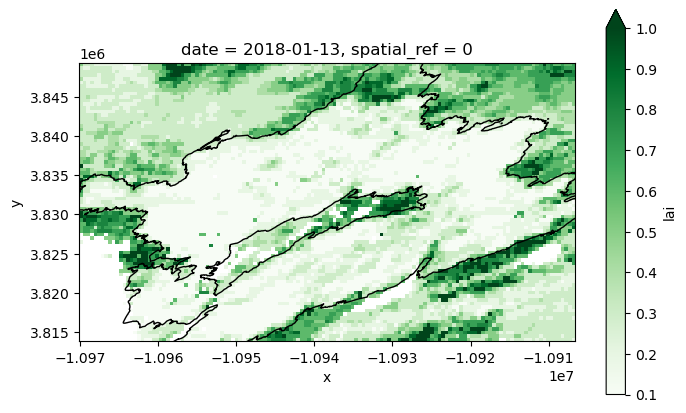

In [21]:
# Set fig
f, ax = plt.subplots(figsize=(8, 5))

# Define stop date
stop_date = '2018-01-13'

# Plot DateArray which contains the stop date
thomas_lai_da.sel({'date': stop_date}, method='backfill').plot(
    ax=ax, cmap='Greens', robust=True)

# Plot fire outline
thomas_sinu_gdf.plot(facecolor='None', ax=ax)

## Plot the LAI inside and outside the fire perimeter

Create a time series plot of the average LAI inside and outside the Thomas Fire perimeter (but within the envelope of the downloaded data).

Start by computing a `GeoDataFrame` of the difference between the Thomas Fire perimeter envelope (e.g. `gdf.envelope`) and the perimeter itself. Call the new `GeoDataFrame` in the cell below

> You can use the `.overlay(gdf, how='difference')` method of `GeoDataFrames` to take the difference

,geometry
0,"MULTIPOLYGON (((-10973717.805 3811755.240, -10..."


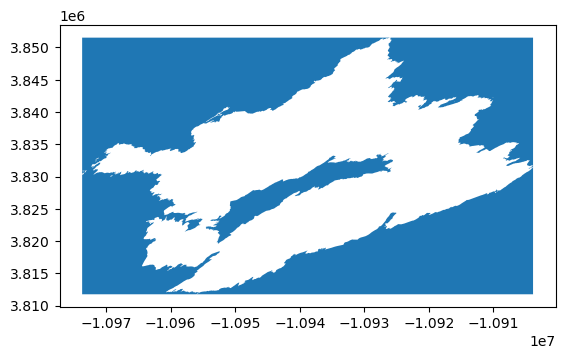

In [22]:
# Compute difference between envelope and perimeter
outside_gdf = gpd.GeoDataFrame(geometry=thomas_sinu_gdf.envelope).overlay(
    thomas_sinu_gdf, how='difference')

# Plot region outside perimeter
outside_gdf.plot()

outside_gdf

In [23]:
ans_outside_gdf = _
outside_gdf_pts = 0

if isinstance(ans_outside_gdf, gpd.GeoDataFrame):
    print('\u2705 Nice work! You returned a GeoDataFrame.')
    outside_gdf_pts += 1
else:
    print('\u274C Check that you returned a GeoDataFrame')

if round(float(ans_outside_gdf.length), 2) == 752360.47:
    print('\u2705 Nice work! Your geometry has the correct length.')
    outside_gdf_pts += 4
else:
    print('\u274C Check that correctly differenced geometries')

print('You received {} of 5 points for differencing geometries'
      .format(outside_gdf_pts))
outside_gdf_pts

✅ Nice work! You returned a GeoDataFrame.
✅ Nice work! Your geometry has the correct length.
You received 5 of 5 points for differencing geometries


5


Next, for both the fire perimeter and the area outside the fire perimeter:
  1. Clip the LAI to the geometry
  2. Take the mean value for each date.
  3. Plot both time series on the same axes, with a legend.

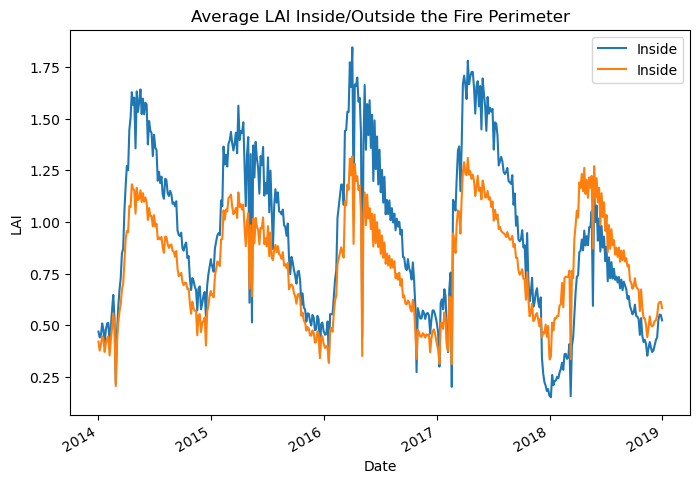

In [24]:
# Set fig
f, ax = plt.subplots(figsize=(8, 5))


def clip_lai(geometry):
    '''
    Clips an inputted geometry to the thomas_lai_da and aggregates LAI by Date

    '''
    return thomas_lai_da.rio.clip(geometry).groupby('date').mean(...)


# Plot inside
clip_lai(thomas_sinu_gdf.geometry).plot(label='Inside')

# Plot outside
clip_lai(outside_gdf.geometry).plot(label='Inside')

# Set plot elements
plt.title('Average LAI Inside/Outside the Fire Perimeter')
plt.xlabel('Date')
plt.ylabel('LAI')
plt.legend()

## Explain your plot

Write an assertion-evidence style headline (as a Markdown Header) and 2-3 bullet points to highlight your results.

### The average leaf area index within the fire perimeter was substantially lower in comparison to previous years, due to the Thomas fire

From the plot we can see the average LAI was significantly lower in comparison to previous years. Right after the fire we can see theres close to 0 LAI, indicating how much vegetation in the area was destroyed, and even in the peak months, the LAI was significantly less than trends prior. The LAI outside of the perimeter doesn't seem to have a change in comparison to previous data. 

## BONUS plot: Animation (10 pts extra credit)

Using a `for` loop, animate each frame of the LAI data from 2017 and 2018 to highlight the change. Check out the second method in this [blog post by Allen Downey on how to do this in Jupyter notebook](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/).

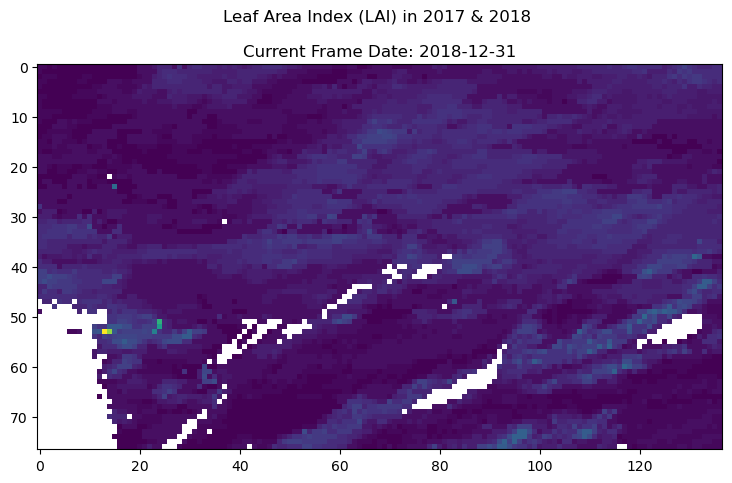

In [25]:
# Define date range
lai_range = thomas_lai_da.loc['2017':'2018']

# Iterate through LAI data and corresponding dates
for index, date in zip(range(len(lai_range)), lai_range['date'].values):
    # Set fig and show LAI frames
    plt.figure(figsize=(10, 5))
    plt.imshow(thomas_lai_da[index])
    plt.title(
        'Leaf Area Index (LAI) in 2017 & 2018 \n\nCurrent Frame Date: '
        f'{pd.to_datetime(date).date()}')
    plt.show()

    # Small pause between frames
    time.sleep(.1)
    # Don't clear last frame
    if (index+1) != len(lai_range):
        clear_output(wait=True)

# I can only get a scale to show when using thomas_lai_da.plot(), but each
# frame has a slightly different scale

# Reproducibility
Notebook runs all the way through. **Make sure to Restart and Run All!**

# Style: PEP-8, Spelling and Grammar, and Comments